In [1]:
import cv2
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy as np
from skimage.segmentation import mark_boundaries

import numpy as np
from scipy import signal

import imutils

import matplotlib.pyplot as plt

In [2]:
def RYB_filters(image):

    nemo = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
    light_red1 =(0, 50, 20)
    dark_red1 = (10, 255, 255)
    
    light_red2 =(160, 45, 20)
    dark_red2 = (180, 255, 255)


    light_white = (0, 0, 200)
    dark_white = (145, 60, 255)

    light_blue = (100,100,0)
    dark_blue = (140,255,255)

    light_yellow = (10,  100, 20)
    dark_yellow = (36, 255, 255)
    
    # Denoising the images
    kernel = np.ones((2,2),np.float32)/4
    
    

    red1_mask = cv2.inRange(hsv_nemo, light_red1, dark_red1)
    red2_mask = cv2.inRange(hsv_nemo, light_red2, dark_red2)
    white_mask = cv2.inRange(hsv_nemo, light_white, dark_white)
    blue_mask = cv2.inRange(hsv_nemo, light_blue, dark_blue)
    yellow_mask = cv2.inRange(hsv_nemo, light_yellow, dark_yellow)

    #filt_mask = cv2.GaussianBlur(white_mask, (3,3),0)
    #filt_mask = cv2.medianBlur(blue_mask,3)    

    im_mask = skimage.segmentation.felzenszwalb(
            skimage.util.img_as_float(nemo), scale=700, sigma= 0.9,
            min_size= 50)



    #####
    white_img  = np.zeros(nemo.shape,dtype=np.uint8)
    white_img.fill(0)
    #####

    bound_img = mark_boundaries(white_img, im_mask)
    ######

    plt.show()
    mask_list = [red1_mask, red2_mask, blue_mask, yellow_mask ,white_mask]
    return mask_list, bound_img

In [3]:
def is_contour_good(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return peri > 35

# contour filter for r2 should be differen we should filter less
def is_contour_good_r2(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return peri > 10

In [4]:
def cont_filter(image,mask_list):
    filtered_masks = []
    count = 1
    for i in mask_list:
        ret,thresh = cv2.threshold(i,127,255,cv2.THRESH_BINARY)
        cnts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        mask = np.ones(image.shape[:2], dtype="uint8") * 255
        # loop over the contours
        if count == 2:
            for c in cnts:
                # if the contour is good, draw it on the mask
                if is_contour_good_r2(c):
                     cv2.drawContours(mask, [c], -1, 0, -1)   
        else:
            for c in cnts:
                # if the contour is good, draw it on the mask
                if is_contour_good(c):
                     cv2.drawContours(mask, [c], -1, 0, -1)
        # remove the contours from the image and show the resulting images
        # image = cv2.bitwise_and(image, image, mask=mask)
        filtered_masks.append(mask)
        count += 1
    return filtered_masks

In [5]:
def display(path):
    image = cv2.imread(path)
    # filter the R(r1,r2) B Y and W colours 
    # mask_list = [red1_mask, red2_mask, blue_mask, yellow_mask ,white_mask]
    mask_list , bound_image = RYB_filters(image)
    filtered_masks = cont_filter(image, mask_list)
    plt.figure(figsize = (30,30))
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(6, 2, 1)
    plt.title("Original")
    plt.imshow(rgb_image)
    
    plt.subplot(6, 2, 2)
    plt.title("Boundries")
    plt.imshow(bound_image, cmap="gray")
    
    name = ['red1_mask', 'red2_mask', 'blue_mask', 'yellow_mask' ,'white_mask']
    for i in range((len(mask_list))*2):
        plt.figure(figsize=(20,20))
        plt.subplot(6,2,i+1+2)
        if i%2==0:
            plt.title(name[i//2])
            plt.imshow(mask_list[i//2], cmap='gray')
            plt.show()
        else:
            plt.title('Filtered'+name[i//2])
            plt.imshow(filtered_masks[i//2], cmap= 'gray')
            plt.show()
            cv2.imwrite('rp_img/fitter_'+str(name[i//2])+'.png',cv2.cvtColor(filtered_masks[i//2], cv2.COLOR_RGB2BGR))
    

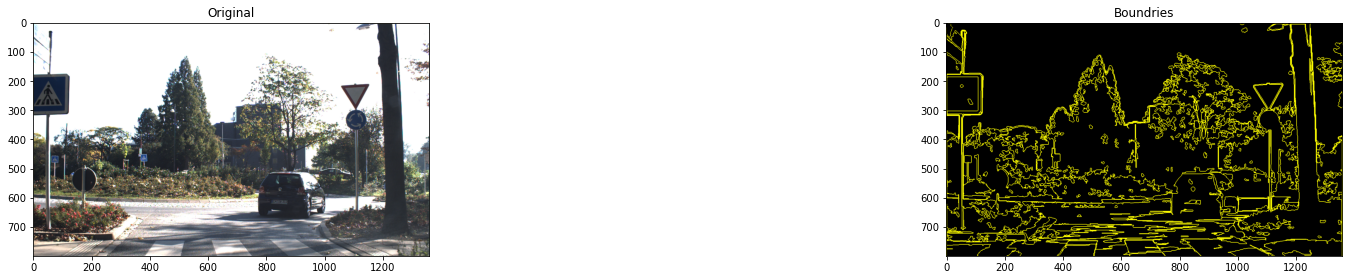

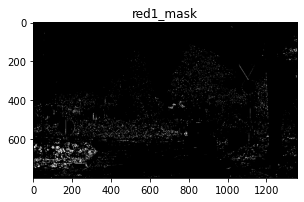

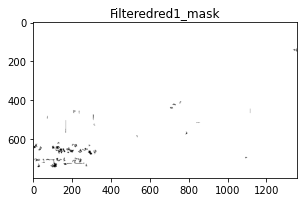

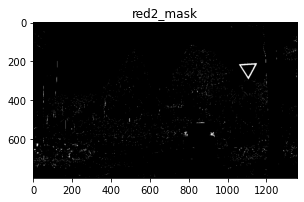

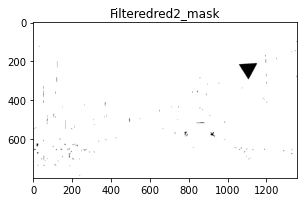

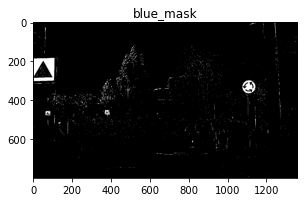

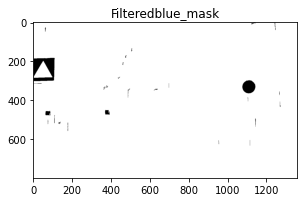

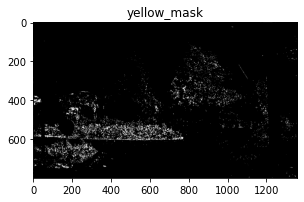

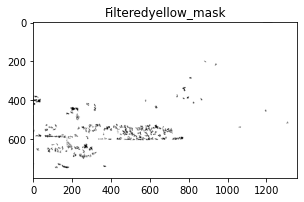

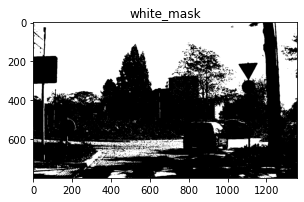

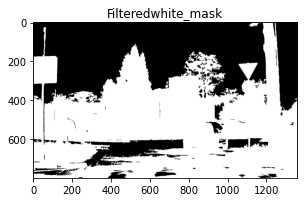

83


In [6]:
for i in range(83,84):
    display('TrainIJCNN2013/000'+str(i)+'.ppm')
    print(i)

# Pixal density in image

In [7]:
img = cv2.imread('TrainIJCNN2013/00077.ppm')

mask_list , bound_image = RYB_filters(img)
fmask_list = cont_filter(img, mask_list)


[red1_mask, red2_mask, blue_mask, yellow_mask ,white_mask] = fmask_list

Number of white pixels: 11168
Number of black pixels: 1076832


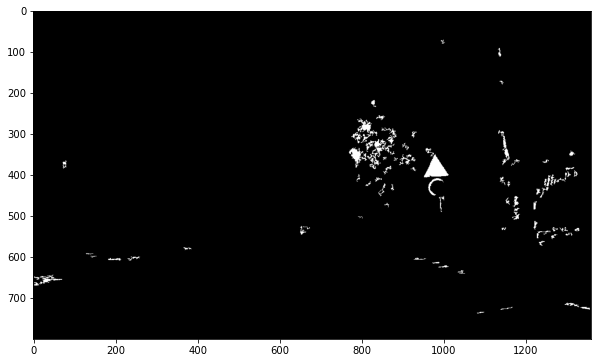

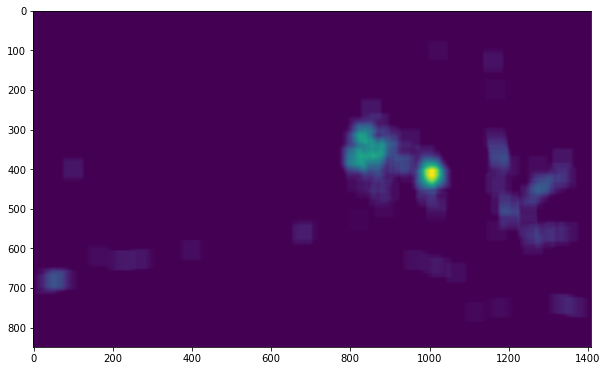

In [8]:
img = red1_mask

img = 255 - img


# counting the number of pixels
number_of_white_pix = np.sum(img == 255)
number_of_black_pix = np.sum(img == 0)
  
print('Number of white pixels:', number_of_white_pix)
print('Number of black pixels:', number_of_black_pix)


a = img
b = np.ones((50,50))
x = signal.convolve2d(a,b, 'full') / (number_of_white_pix)
# normalizing array
norm = np.sum(x)
x = x/norm
x = x

plt.figure(figsize = (10,10))               
plt.imshow(a,cmap = 'gray')
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(x)
plt.show()
print()